# Hierarchical Multinomial Logit (HMNL) with Liesel

This notebook demonstrates the implementation of a Hierarchical Multinomial Logit model using the **Liesel** library and **JAX**.

**Key Components:**
* **Data Generation:** Simulates synthetic choice data for multiple individuals (units) choosing between different alternatives.
* **Model Specification:** Defines a Bayesian hierarchical model where individual preferences ($\beta$) are drawn from a unit-level ("per person") distribution.
* **Inference:** Uses the No-U-Turn Sampler (NUTS) via `liesel.goose` to estimate posterior distributions.
* **Analysis:** visualizes parameter recovery and convergence (trace plots).

In [1]:
import jax
import jax.numpy as jnp

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import liesel.model as lsl
import liesel.goose as gs
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

# Set random seed for reproducibility
key = jax.random.PRNGKey(42)

## Utility Distributions

We define a custom `InverseWishart` distribution class. In hierarchical models, the Inverse Wishart distribution is commonly used as a conjugate prior for the covariance matrix of a multivariate normal distribution. Unfortunately it is not implemented in the tfd library and needs a workaround. Therefore, a custom class is designed, which uses the tfd.WishartTriL class (Wishart distribution with lower Triangular Cholesky matix) and uses chained bijectors to transform it to the Inverse Wishart.

In [2]:
class InverseWishart(tfd.TransformedDistribution):
    """
    Inverse Wishart distribution over positive definite matrices.
    
    If W ~ Wishart(df, Psi^{-1}), then Sigma = W^{-1} ~ InverseWishart(df, Psi).
    
    Args:
        df: Degrees of freedom (must be > dimension - 1).
        scale: Scale matrix (Psi), must be positive definite and symmetric.
    """
    
    def __init__(self, df, scale, **kwargs):
        # Convert parameters to JAX arrays for consistency.
        self._df = jnp.asarray(df)
        self._scale = jnp.asarray(scale)
        
        # The Inverse Wishart is implemented by transforming a Wishart whose scale is Psi^{-1}.
        # The WishartTriL distribution requires a Cholesky factor of its scale matrix, so we compute:
        # L = chol((Psi)^{-1})
        wishart_scale_tril = jnp.linalg.cholesky(jnp.linalg.inv(self._scale))

        # Define the base Wishart distribution W ~ Wishart(df, Psi^{-1})
        base_dist = tfd.WishartTriL(df=self._df, scale_tril=wishart_scale_tril)
        
        # Bijector converting a Wishart-distributed matrix W into an
        # Inverse Wishart-distributed matrix Sigma = W^{-1}.
        #
        # Steps (applied from right to left):
        #   1. CholeskyOuterProduct(): Convert lower-triangular Cholesky factor
        #      to the full positive-definite matrix W.
        #   2. CholeskyToInvCholesky(): Convert W to its inverse via the
        #      Cholesky factor of W^{-1}.
        #   3. CholeskyOuterProduct(): Convert the Cholesky factor of W^{-1}
        #      back to the full matrix Sigma = W^{-1}.
        bijector = tfb.Chain([
            tfb.CholeskyOuterProduct(),
            tfb.CholeskyToInvCholesky(),
            tfb.Invert(tfb.CholeskyOuterProduct())
        ])
        
        # Initialize parent class
        super().__init__(
            distribution=base_dist,
            bijector=bijector,
            **kwargs
        )
        
        # Register parameters so that TFP can serialize this distribution
        self._parameters = dict(df=self._df, scale=self._scale)
    
    @property
    def df(self):
        """Degrees of freedom parameter."""
        return self._df
    
    @property
    def scale(self):
        """Scale matrix parameter."""
        return self._scale

## Hierarchical Multinomial Logit Data Simulation

The `simulate_data` function generates synthetic data for a **Hierarchical Multinomial Logit (MNL)** model with 100 units (50 small, 50 large) and 5 alternatives (choices).

The key steps are:
1.  **Generate Unit-Level Parameters ($\beta_i$)**: The individual unit parameters ($\beta_i$) are sampled from a $\text{Multivariate Normal}$ distribution: $\beta_i \sim N(\mu, \Sigma)$.
2.  **Define Design Matrix ($\mathbf{X}$)**: The matrix $\mathbf{X}$ is constructed for a choice task with 5 alternatives (Alt 5 is the base) and 5 parameters (4 intercepts + 1 price slope).
3.  **Calculate Utility ($\mathbf{V}$)**: The utility for each observation is calculated using the linear-in-parameters form: $\mathbf{V} = \mathbf{X} \cdot \beta_i$.
4.  **Calculate Probabilities ($\mathbf{P}$)**: Choice probabilities are derived using the **Softmax** (MNL) function: $\mathbf{P} = \text{Softmax}(\mathbf{V})$.
5.  **Sample Choices ($\mathbf{y}$)**: The final choices ($\mathbf{y}$) are sampled from a $\text{Categorical}$ distribution based on the calculated probabilities.

### Key Parameters and Distributions

| Parameter | Value | Description |
| :--- | :--- | :--- |
| $\text{N}_{\text{Units}}$ | 100 | Number of distinct decision-making units |
| $\text{N}_{\text{Alts}}$ | 5 | Number of alternatives in each choice task |
| $\text{N}_{\text{Params}}$ | 5 | Number of parameters (4 intercepts, 1 price slope). Only 4 intercepts, since 1 base choice is needed for comparison |
| $\mu$ | $(1, -1, 0, 0, -3)$ | Mean vector for the $\beta_i$ prior |
| $\Sigma$ | Diagonal elements 3.0; $\Sigma_{4,5} = \Sigma_{5,4} = 1.5$ | Covariance matrix for the $\beta_i$ prior |
| $\text{Price } X$ | $\sim \text{Uniform}(-1.5, 0.0)$ | log-price variable for all alternatives |

### Model Structure (Mathematical Notation)

The unit-specific parameters ($\beta_i$) and the utility ($V_{itj}$) are defined as:

$$\beta_i \sim N(\mu, \Sigma)$$

$$V_{itj} = \mathbf{X}_{itj} \cdot \beta_i$$

Where:
* $\mathbf{X}_{itj}$ is the **design vector** for observation $t$ within unit $i$ for alternative $j$.
* $\beta_i$ is the **parameter vector** for unit $i$.

The probability of choosing alternative $j$ in observation $t$ for unit $i$ is given by the **Multinomial Logit (Softmax)** formula:

$$P(y_{it} = j) = \frac{\exp(V_{itj})}{\sum_{k=1}^{5} \exp(V_{itk})}$$

### Output

The function returns a dictionary containing the simulated design matrix ($\mathbf{X}$), choices ($\mathbf{y}$), unit indices, observation counts, and the true hyperparameters ($\mu$, $\Sigma$) and unit parameters ($\beta_i$).

In [3]:
def simulate_data(seed):

    # Genearte seed and split into sub-keys
    key = jax.random.PRNGKey(seed)
    k1, k2, k3 = jax.random.split(key, 3)
    
    # --- Parameters from Rossi et al. ---
    n_units = 100
    n_obs_small = 5
    n_obs_large = 50
    n_alts = 5
    n_params = 5 # 4 intercepts + 1 slope
    
    # Units setup: 50 with 5 obs, 50 with 50 obs
    counts = jnp.array([n_obs_small] * 50 + [n_obs_large] * 50)
    unit_idx = jnp.repeat(jnp.arange(n_units), counts)              # Mapping obs -> unit
    
    # True Hyperparameters for beta_i prior
    # mu = (1, -1, 0, 0, -3)
    true_mu = jnp.array([1.0, -1.0, 0.0, 0.0, -3.0])
    
    # V_beta (Sigma): Diagonal=3, (4,5) and (5,4)=1.5 #
    # adapted for python indices (3,4)
    true_Sigma = 3.0 * jnp.eye(n_params)
    true_Sigma = true_Sigma.at[3, 4].set(1.5)
    true_Sigma = true_Sigma.at[4, 3].set(1.5)
    
    # Generate Unit Level Bet as
    # beta_i ~ N(mu, Sigma)
    beta_dist = tfd.MultivariateNormalFullCovariance(loc=true_mu, covariance_matrix=true_Sigma)
    betas = beta_dist.sample(seed=k1, sample_shape=(n_units,))
    
    # --- Generate X and Choices ---
    # X ~ Uniform(-1.5, 0)
    # Structure: We need a design matrix for MNL.
    # Utilities: U_j = alpha_j + beta * price_j
    # Design Matrix shape per choice task: (5 alternatives, 5 parameters)
    # Cols 0-3: Intercept dummies (Alt 5 is base)
    # Col 4: Price variable
    
    X_list = []
    y_list = []
    
    for i in range(n_units):
        n_i = counts[i]
        beta_i = betas[i]
        
        # Generate Price X for this unit's observations
        # Shape: (n_i, n_alts)
        k2, sk = jax.random.split(k2)
        price = jax.random.uniform(sk, shape=(n_i, n_alts), minval=-1.5, maxval=0.0)
        
        # Build Design Matrix D: (n_i, n_alts, n_params)
        D = jnp.zeros((n_i, n_alts, n_params))
        
        # Set intercepts for first 4 alternatives
        for a in range(4):
            D = D.at[:, a, a].set(1.0)
            
        # Set price slope (column 4) for all alternatives
        D = D.at[:, :, 4].set(price)
        
        # Calculate Utility: V = D @ beta
        # (n_i, 5, 5) @ (5,) -> (n_i, 5)
        V = jnp.einsum('ijk,k->ij', D, beta_i)
        
        # Probabilities (Softmax)
        probs = jax.nn.softmax(V, axis=1)
        
        # Sample Choices
        k3, sk = jax.random.split(k3)
        choices = tfd.Categorical(probs=probs).sample(seed=sk)
        
        X_list.append(D)
        y_list.append(choices)
        
    X_data = jnp.concatenate(X_list, axis=0)
    y_data = jnp.concatenate(y_list, axis=0)
    
    return {
        "X": X_data,
        "y": y_data,
        "unit_idx": unit_idx,
        "counts": counts,
        "true_mu": true_mu,
        "true_Sigma": true_Sigma,
        "true_betas": betas
    }

data = simulate_data(42)
print("Total Observations:", data["y"].shape)

Total Observations: (2750,)


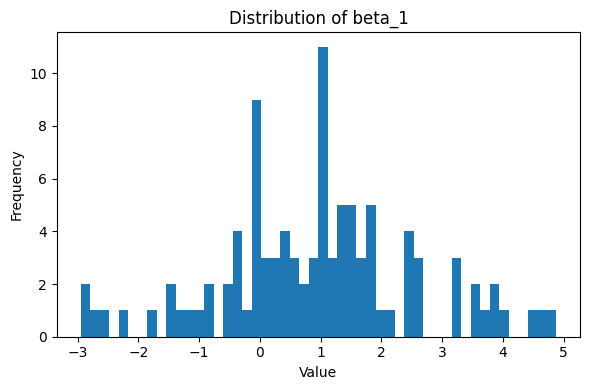

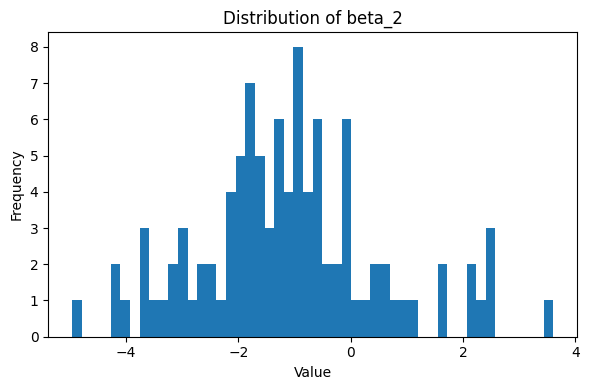

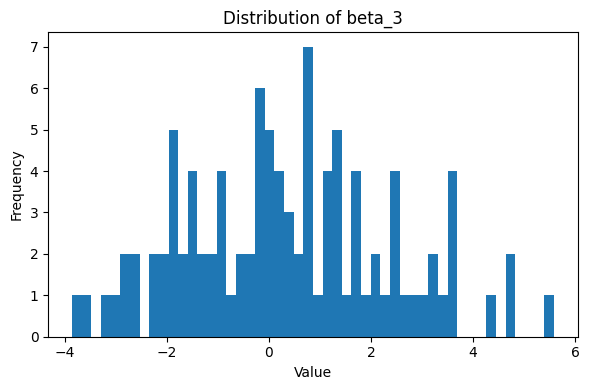

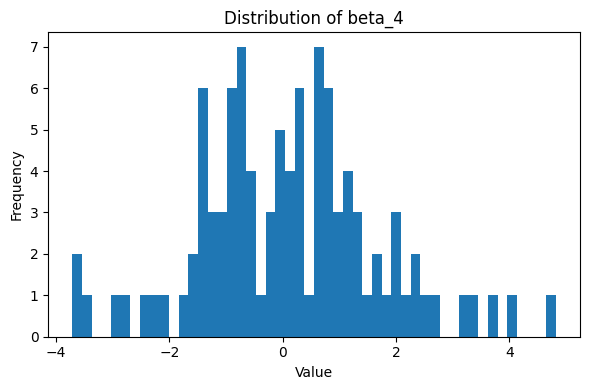

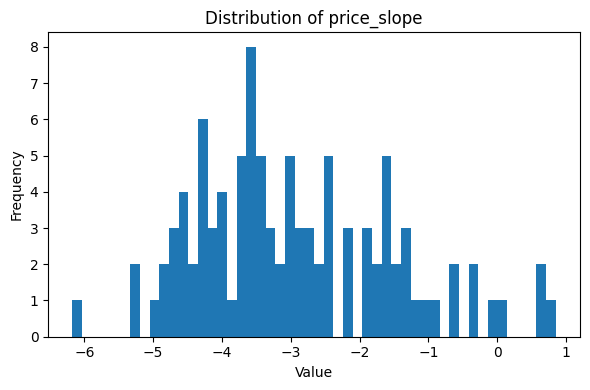

In [4]:
# Plot simulated beta distributions
betas = np.array(data["true_betas"])
param_names = ["beta_1", "beta_2", "beta_3", "beta_4", "price_slope"]

for p in range(5):
    plt.figure(figsize=(6, 4))
    plt.hist(betas[:, p], bins=50)
    plt.title(f"Distribution of {param_names[p]}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


## Hierarchical Bayesian MNL Model

### 1. Population Priors (Hyperparameters)

The model uses **diffuse (uninformative) priors** for the population parameters to ensure the data dominates the estimation. The model has $k=5$ parameters per unit.

| Parameter | Prior Distribution | Role |
| :--- | :--- | :--- |
| $\Sigma$ | $\text{Inverse-Wishart}(\nu=5+3, \mathbf{V}=8\mathbf{I})$ | **Population Heterogeneity:** Controls the variance of individual $\beta_i$'s. |
| $\mu$ | $\text{MultivariateNormal}(\mathbf{0}, \Sigma / \mathbf{A})$ | **Population Mean:** Center of individual $\beta_i$ distribution. The $\mathbf{A}=0.01$ precision factor makes the prior  diffuse. |

### 2. Unit-Level Parameters (Random Effects)

The individual preference vectors ($\beta_i$) are the **Random Effects**, linked to the population distribution:
$$\beta_i \sim \text{MultivariateNormal}(\mu, \Sigma)$$
There are 100 such vectors, one for each unit.

### 3. Likelihood (Multinomial Logit)

The observed choices ($\mathbf{y}$) are modeled using the MNL structure:

1.  **Utility/Logits ($\mathbf{V}$)**: Calculated as $\mathbf{V} = \mathbf{X} \cdot \beta_i$.
2.  **Likelihood**: The final choice probability is $\text{Categorical}(\text{Softmax}(\mathbf{V}))$.

The LSL framework links the data ($\mathbf{X}$, $\mathbf{y}$, and `unit_idx`) to the hierarchical parameters to define the complete model.

liesel.model.viz - WARNING - Graphviz not found in PATH. Using fallback graph layout. Consider installing Graphviz: https://graphviz.org/download


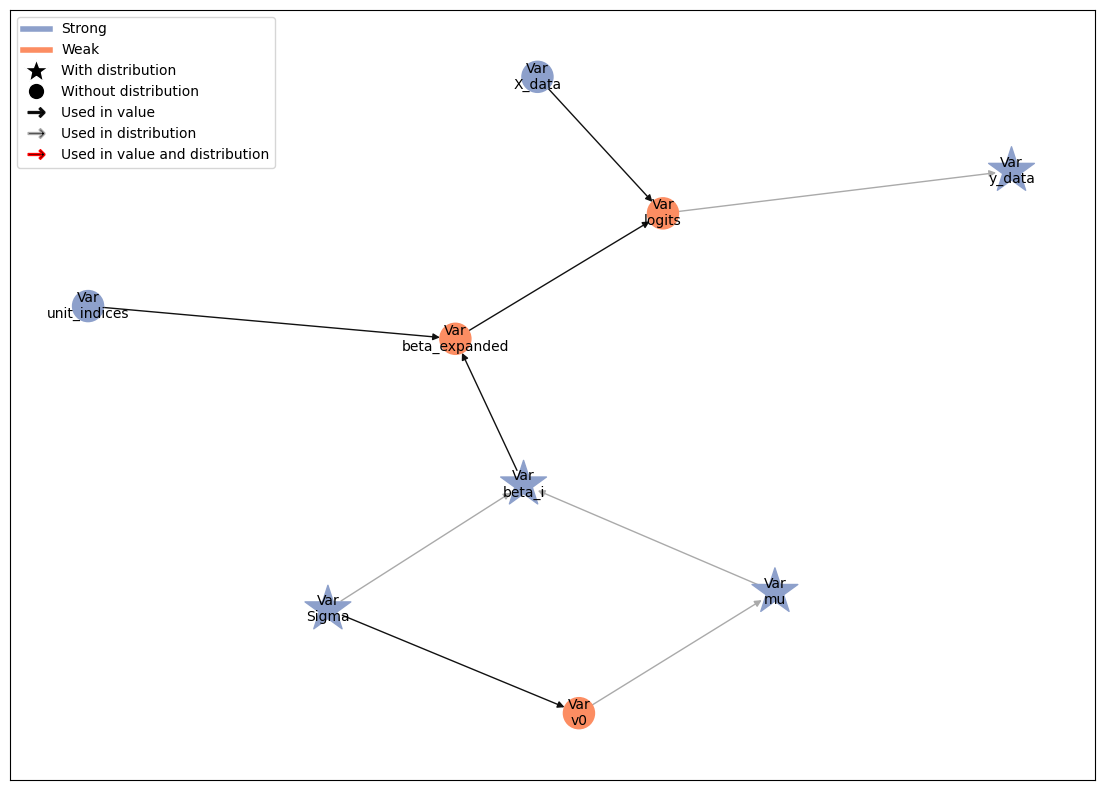

In [5]:
# --- 1. Hyperparameter Setup (Standard Diffuse Priors) ---
# k_dim: Number of covariates/parameters per unit (5)
k_dim = 5

# Degrees of Freedom (nu): 
nu = k_dim + 3

# Scale Matrix (V):
V = nu * jnp.eye(k_dim)

# Precision Scaling (A):
# In Rossi eq (5.4.1), the variance of delta/mu is scaled by A^-1.
# A = 0.01 implies a variance scaling of 100.
A = 0.01 

# --- 2. Population-Level Parameters (Hyperparameters) ---

# Sigma (Population Heterogeneity):
# Corresponds to V_beta in Rossi notation.
# Controls how much individual units (beta_i) deviate from the population mean (mu).
Sigma_prior_dist = lsl.Dist(InverseWishart, df=float(nu), scale=V)
Sigma = lsl.Var.new_param(jnp.eye(k_dim), distribution=Sigma_prior_dist, name="Sigma")

# Mu (Population Mean):
# Corresponds to Delta in Rossi eq (5.4.1) when Z is just an intercept.
# -------------------------------------------------------------------------
# Prior:
# Rossi specifies: vec(Delta | V_beta) ~ N(vec(Delta_bar), V_beta (x) A^-1)
# 
# 1. Delta_bar (Prior Mean): We set this to 0 (diffuse).
#    This states that our prior belief centers at zero, but the variance is large
#    so the model will likely find the true mu and not be dominated by the prior
#
# 2. Covariance (Sigma / A): 
#    Since we have no unit-level covariates (Z is implicit column of ones), 
#    A is a scalar. The Kronecker product V_beta (x) A^-1 simplifies to:
#    Sigma * (1/A) or Sigma / A.
# -------------------------------------------------------------------------
mu_prior_dist = lsl.Dist(
    tfd.MultivariateNormalFullCovariance,
    loc=jnp.zeros(k_dim),                   # prior mean (Delta_bar)
    covariance_matrix=lsl.Var.new_calc(
        lambda s: s / A, s=Sigma            # prior covariance (Sigma (x) A^-1)
    )
)
mu = lsl.Var.new_param(jnp.zeros(k_dim), distribution=mu_prior_dist, name="mu")

# --- 3. Unit-Level Parameters (Random Effects) ---

# Beta_i (Individual Preferences):
# Equation: beta_i = mu + u_i, where u_i ~ N(0, Sigma)
# This is equivalent to: beta_i ~ N(mu, Sigma)
beta_dist = lsl.Dist(
    tfd.MultivariateNormalFullCovariance,
    loc=mu,
    covariance_matrix=Sigma
)

# Initialize betas for 100 units
n_units = 100
beta_i = lsl.Var.new_param(
    jnp.zeros((n_units, k_dim)), 
    distribution=beta_dist, 
    name="beta_i"
)

# --- 4. Likelihood Logic (Multinomial Logit) ---

# Data Containers
X_var = lsl.Var.new_obs(data["X"], name="X_data")                # Shape: (N_total, 5_alts, 5_params)
idx_var = lsl.Var.new_obs(data["unit_idx"], name="unit_indices") # Shape: (N_total,)

# Broadcast Parameters:
# We map the 100 unit-level betas to the thousands of observations.
# If observation n belongs to unit 5, we grab beta_i[5].
beta_expanded = lsl.Var.new_calc(
    lambda b, idx: b[idx], 
    b=beta_i, 
    idx=idx_var, 
    name="beta_expanded"
)

# Compute Logits (Utility):
# Calculates U_nj = X_nj * beta_n
# einsum "nij, nj -> ni":
#   n: observation index
#   i: alternative index (0-4)
#   j: parameter index (0-4)
# Result is (N_obs, 5_alts) - a utility score for each alternative.
logits = lsl.Var.new_calc(
    lambda x, b: jnp.einsum("nij,nj->ni", x, b),
    x=X_var,
    b=beta_expanded,
    name="logits"
)

# Likelihood Distribution:
# Categorical distribution uses softmax internally on the logits to get probabilities.
likelihood_dist = lsl.Dist(tfd.Categorical, logits=logits)

# --- 5. Observe Data ---
y_var = lsl.Var.new_obs(
    data["y"], 
    distribution=likelihood_dist, 
    name="y_data"
)

# --- 6. Model Assembly ---
model = lsl.Model([y_var])
model.plot_vars()

In [6]:
# Create Interface
interface = gs.LieselInterface(model)

# Setup Builder ()
eb = gs.EngineBuilder(seed=100, num_chains=4)

eb.set_model(interface)
eb.set_initial_values(model.state)

# Add Kernels
# Use NUTS for Hyperparameters (not applied druing time of Rossi paper(2006), but works really well)
eb.add_kernel(gs.NUTSKernel(["mu"]))                                
eb.add_kernel(gs.NUTSKernel(["Sigma"]))                 # seems to still missbehave

# NUTS for Unit-Level Betas (500 latent parameters)
eb.add_kernel(gs.NUTSKernel(["beta_i"]))

# Set samplig duration and parameters 
eb.set_duration(warmup_duration=1000, posterior_duration=5000, thinning_posterior=1)

# 5. Build
engine = eb.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [7]:
# Cell 6: Run Sampling
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:28<00:00,  9.64s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 2, 3, 2 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 64, 65, 57, 57 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 2, 2, 1, 2 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 260.27chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 3, 1, 2, 1 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 21, 23, 22, 20 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 1, 1, 1, 1 / 25 transitions
liesel.goose.engine - INFO - Finished ep

# Model Diagnostics

In [8]:
# Extract Results
results = engine.get_results()
samples = results.get_posterior_samples()

# Create summary for numerical diagnostics 
summary = gs.Summary(results)
# display(summary)
# (R-hat < 1.05 indicates convergence)

In [9]:
def plot_detailed_param(results_dict, param_name, param_indices):
    """
    Plot detailed diagnostics for a parameter.
    param_indices can be a single int or list of ints.
    """
    if isinstance(param_indices, int):
        param_indices = [param_indices]
    for idx in param_indices:
        print(f"Detailed Diagnostics: {param_name}[{idx}]")
        gs.plot_param(results_dict, param_name, param_index=idx)
        plt.show()


 Global Mu Trace Plots


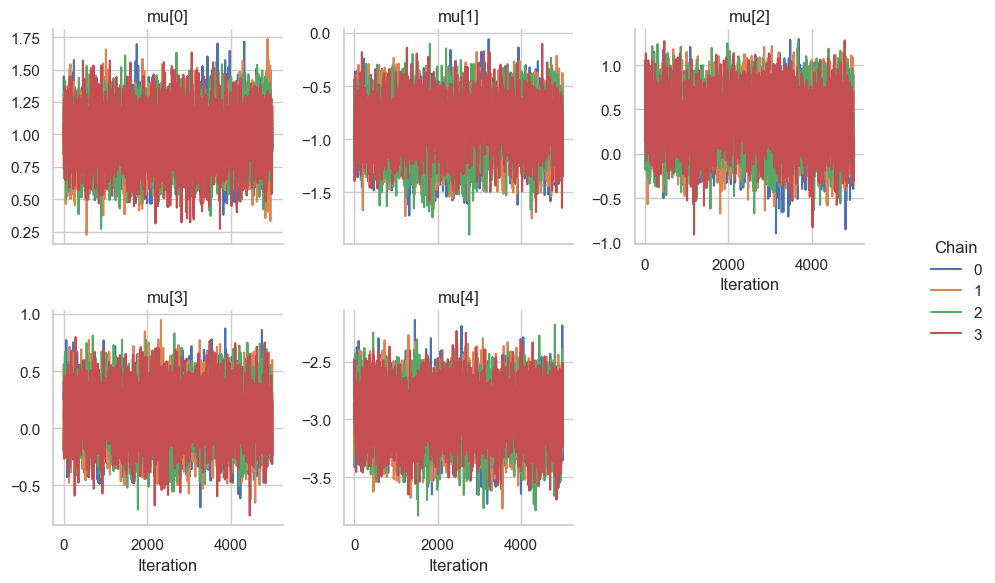


Detailed Mu Parameter Diagnostics
Detailed Diagnostics: mu[0]


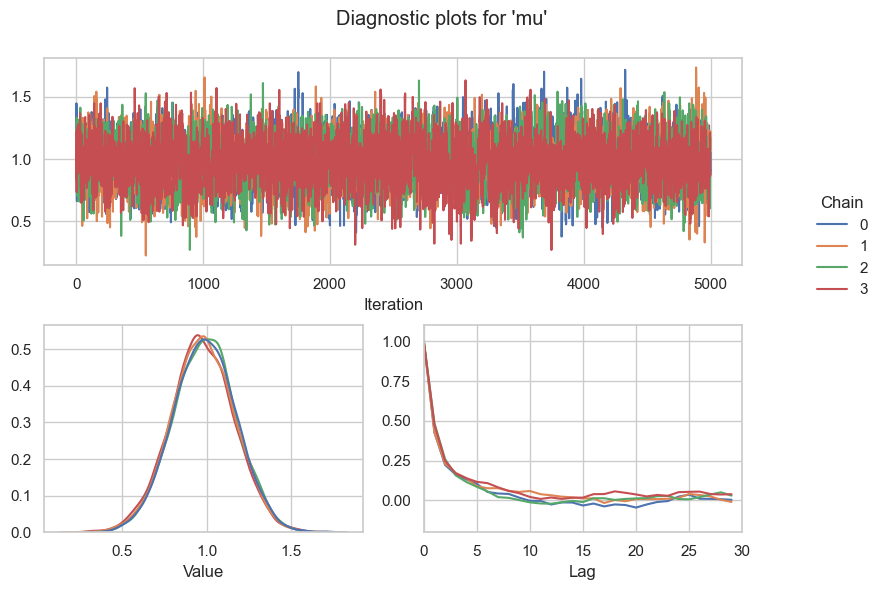

Detailed Diagnostics: mu[1]


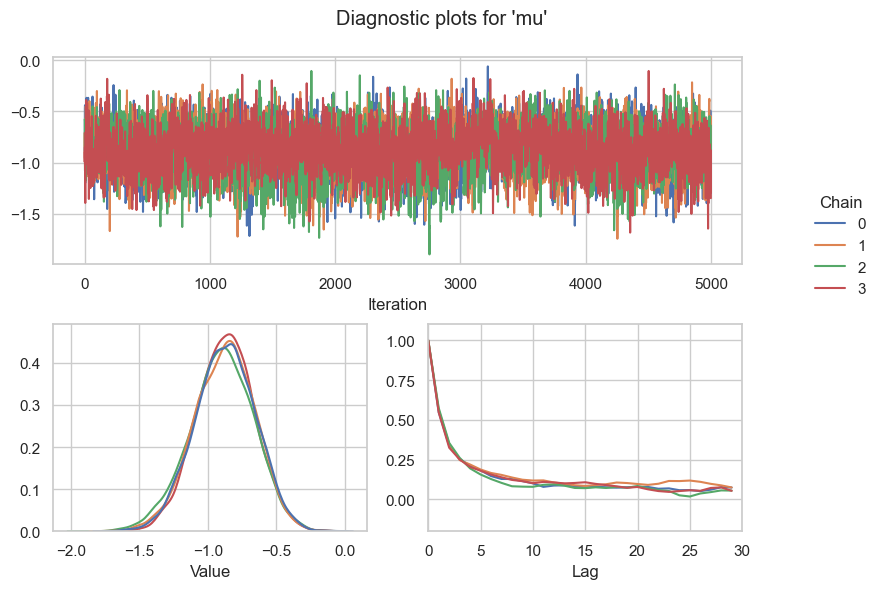

Detailed Diagnostics: mu[2]


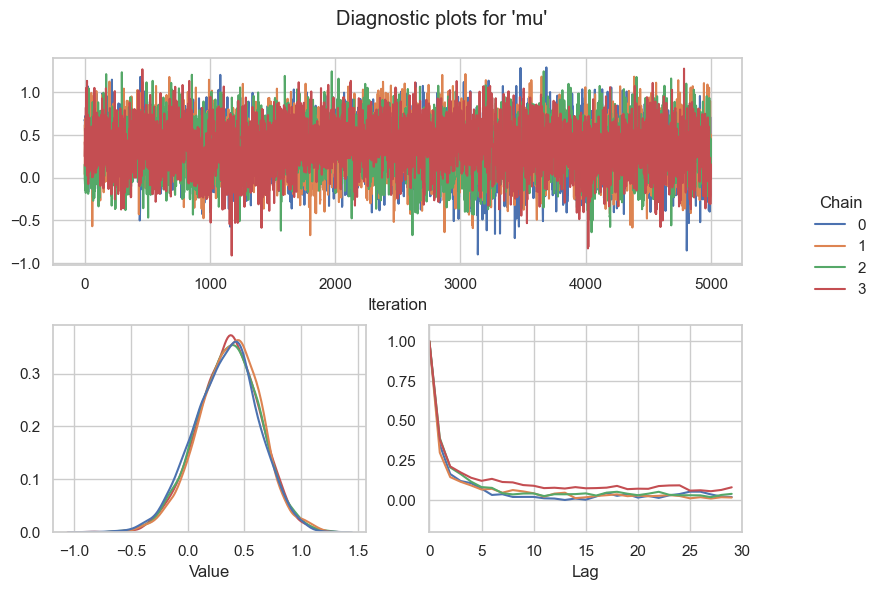

Detailed Diagnostics: mu[3]


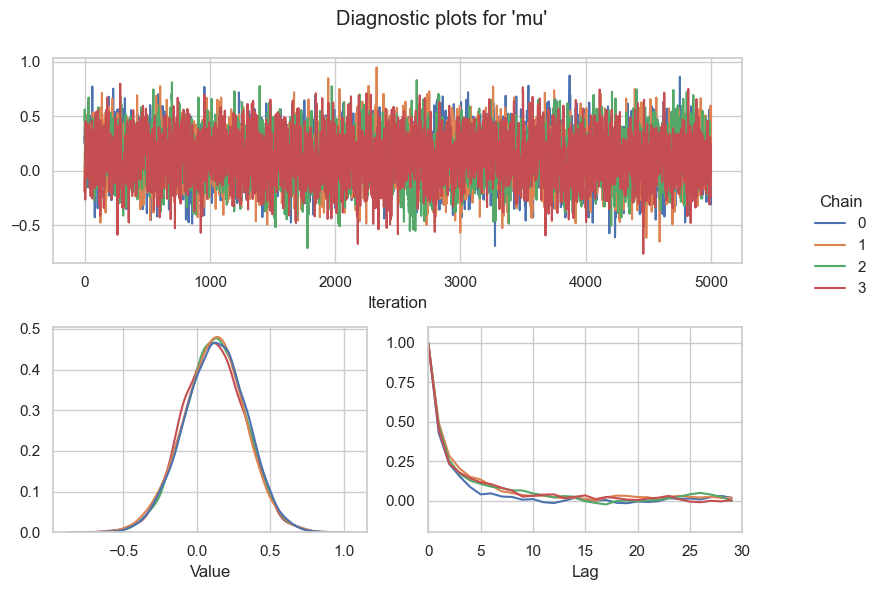

Detailed Diagnostics: mu[4]


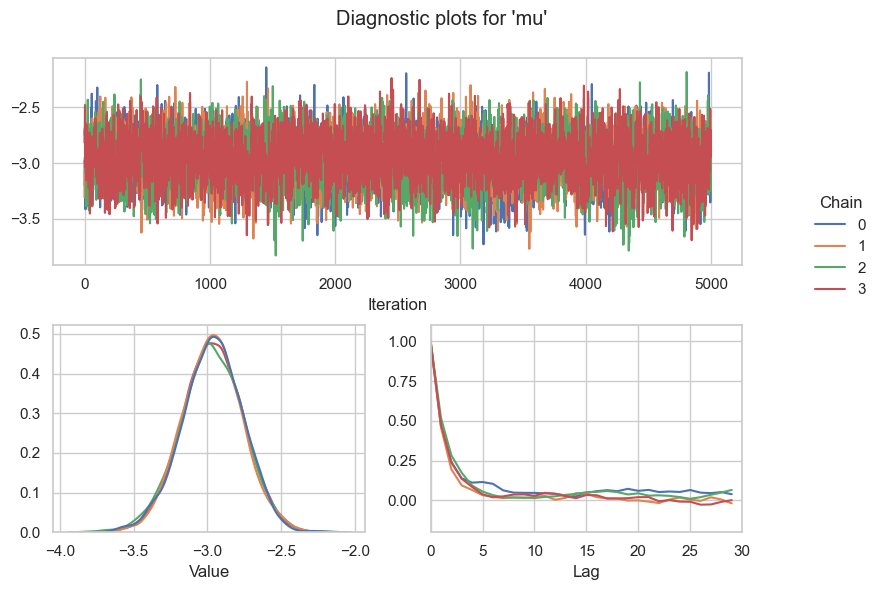


Sigma Covariance Matrix Diagnostics
Trace Plot: Sigma[0,0] (Variance of Intercept)


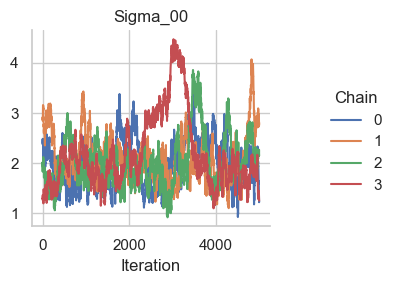

Trace Plot: Sigma[4,4] (Variance of Price Slope)


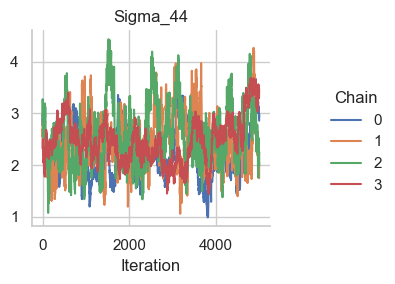

In [10]:
# =======================
# CONVERGENCE DIAGNOSTICS
# =======================

# Global mu Diagnostics
print("\n Global Mu Trace Plots")
gs.plot_trace(results, "mu")
plt.show()

print("\nDetailed Mu Parameter Diagnostics")
plot_detailed_param(results, "mu", param_indices=range(5))
plt.show()

# Sigma Diagnostics
print("\nSigma Covariance Matrix Diagnostics")
# Extract diagonal elements from 4D Sigma array
sigma_00_trace = samples["Sigma"][..., 0, 0]  # Variance of intercept
sigma_44_trace = samples["Sigma"][..., 4, 4]  # Variance of price slope

temp_results_sigma = {
    "Sigma_00": sigma_00_trace,
    "Sigma_44": sigma_44_trace
}

print("Trace Plot: Sigma[0,0] (Variance of Intercept)")
gs.plot_trace(temp_results_sigma, "Sigma_00")
plt.show()

print("Trace Plot: Sigma[4,4] (Variance of Price Slope)")
gs.plot_trace(temp_results_sigma, "Sigma_44")
plt.show()

In [11]:
# ===============================
# POSTERIOR SUMMARY STATISTICS
# ===============================

# Extract information about beta_i samples
chains, samples_num, n_units, n_params = samples["beta_i"].shape

# Beta_i Summary Statistics
print("\n Beta_i (Unit-Level Parameters) Summary")
beta_posterior_means = jnp.mean(samples["beta_i"], axis=(0, 1))  # (units, parameters)
beta_posterior_stds = jnp.std(samples["beta_i"], axis=(0, 1))    # (units, parameters)

print(f"Shape: {beta_posterior_means.shape} (units x parameters)")
print("\nPosterior Means:")
print(beta_posterior_means)
print("\nPosterior Std Dev:")
print(beta_posterior_stds)

# Mu Summary Statistics 
print("\n Mu (Global Parameters) Summary")
mu_posterior_means = jnp.mean(samples["mu"], axis=(0, 1))  # (units, params)
mu_posterior_stds = jnp.std(samples["mu"], axis=(0, 1))

print(f"Shape: {mu_posterior_means.shape}")
print("\nPosterior Means:")
print(mu_posterior_means)
print("\nSimluated Means:")
print([1,-1,0,0,-3])
print("\nPosterior Std Dev:")
print(mu_posterior_stds)


 Beta_i (Unit-Level Parameters) Summary
Shape: (100, 5) (units x parameters)

Posterior Means:
[[ 0.15378799 -1.1736828   1.4858353  -0.50673336 -3.6518257 ]
 [ 0.62306005  0.32486126 -0.8310339  -1.4118491  -4.3967957 ]
 [ 0.48486665 -0.53708786  1.5848631   0.49149764 -3.5860553 ]
 [ 0.33842948 -0.9061283  -2.0727303  -1.220437   -3.7263694 ]
 [-0.47456807 -0.83992106 -1.7055113   1.3634818  -2.0744474 ]
 [ 1.5116638   0.05876878  0.13903248 -0.7665103  -3.6045938 ]
 [ 1.1233816  -0.1612334   1.7072203  -0.66793174 -3.438891  ]
 [ 2.3261046  -1.4008915   0.48973367 -0.8588546  -2.5151875 ]
 [ 1.0029168  -1.2645864  -1.0265626   2.2214422  -2.0918744 ]
 [ 2.5671136  -1.4758202  -0.9659567   0.24265678 -1.9050627 ]
 [-0.09981851 -1.4869611  -1.3076441   2.834515   -1.7057855 ]
 [ 2.2659447  -1.3514978  -0.6266206   0.00985481 -2.879338  ]
 [ 2.1403847   0.77423894  0.43858397 -0.7064191  -2.5835729 ]
 [ 1.0170739  -1.3111941   2.770397    0.6829205  -2.0132446 ]
 [ 2.1532385   0.20647


Unit-Level Parameter Recovery (All Parameters)


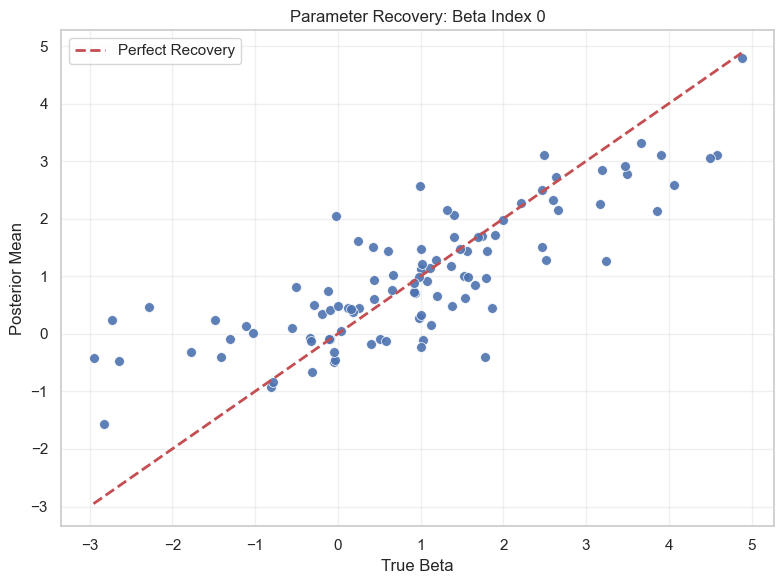

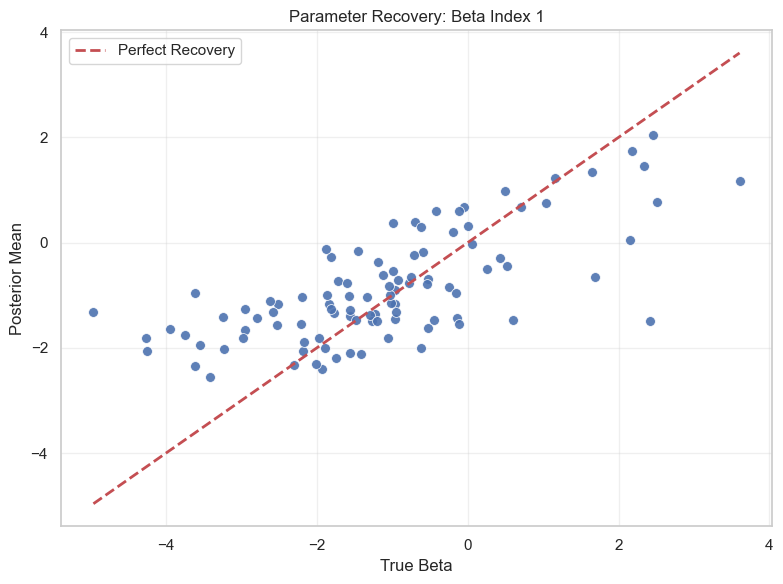

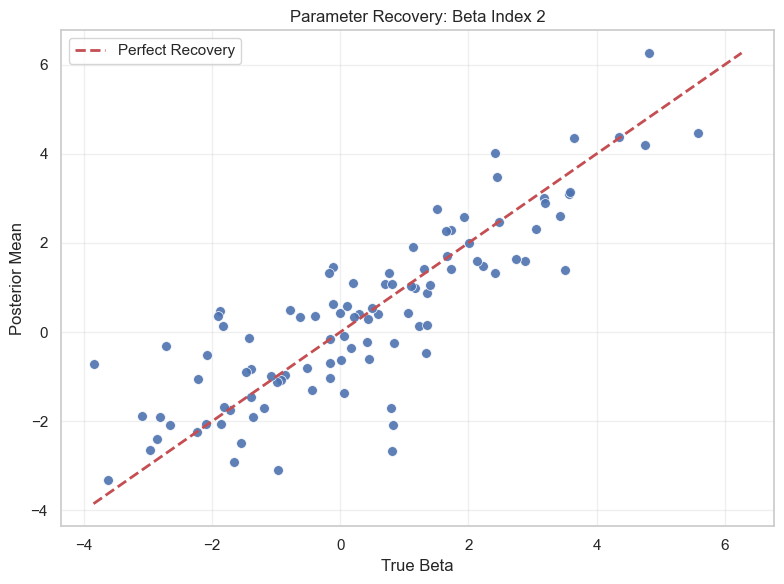

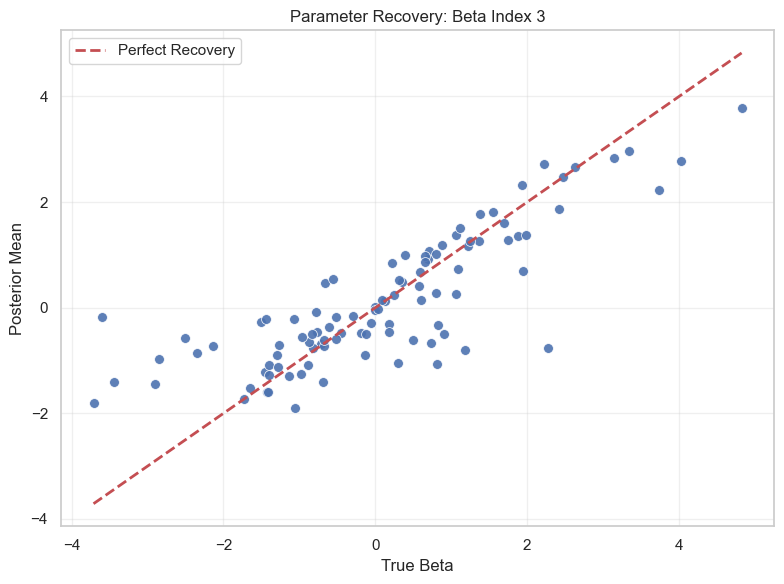

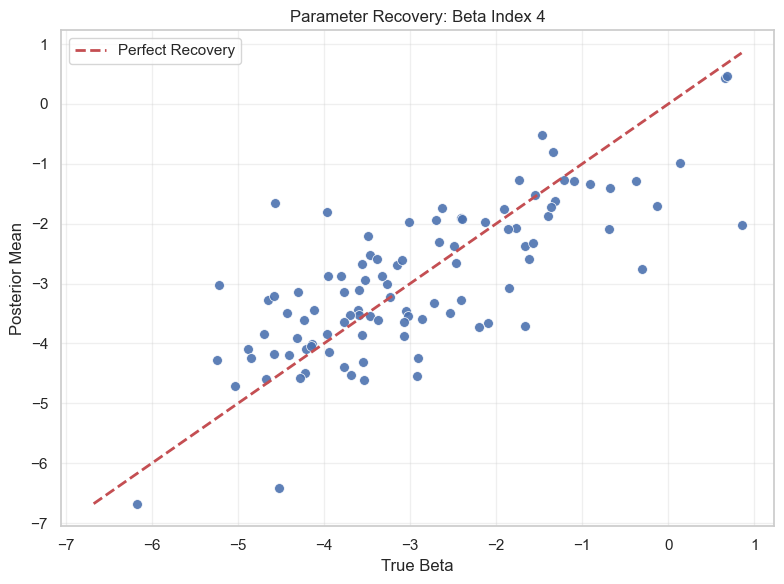


Recovery Quality
Parameter 0, Correlation=0.8134
Parameter 1, Correlation=0.7104
Parameter 2, Correlation=0.8463
Parameter 3, Correlation=0.8312
Parameter 4, Correlation=0.7583


In [12]:
# ==================
# PARAMETER RECOVERY
# ==================

if "true_betas" in data:
    print("\nUnit-Level Parameter Recovery (All Parameters)")
    for param_idx in range(n_params):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x=data["true_betas"][:, param_idx],
            y=beta_posterior_means[:, param_idx],
            alpha=0.9,
            s=50
        )
        
        # Identity line
        min_val = min(data["true_betas"][:, param_idx].min(), 
                     beta_posterior_means[:, param_idx].min())
        max_val = max(data["true_betas"][:, param_idx].max(), 
                     beta_posterior_means[:, param_idx].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', 
                linewidth=2, label="Perfect Recovery")
        
        plt.xlabel("True Beta")
        plt.ylabel("Posterior Mean")
        plt.title(f"Parameter Recovery: Beta Index {param_idx}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Compute recovery quality
    print("\nRecovery Quality")
    for param_idx in range(n_params):
        true_vals = data["true_betas"][:, param_idx]
        est_vals = beta_posterior_means[:, param_idx]
        corr = np.corrcoef(true_vals, est_vals)[0, 1]
        print(f"Parameter {param_idx}, Correlation={corr:.4f}")


Boxplots (Posterior Ranges)


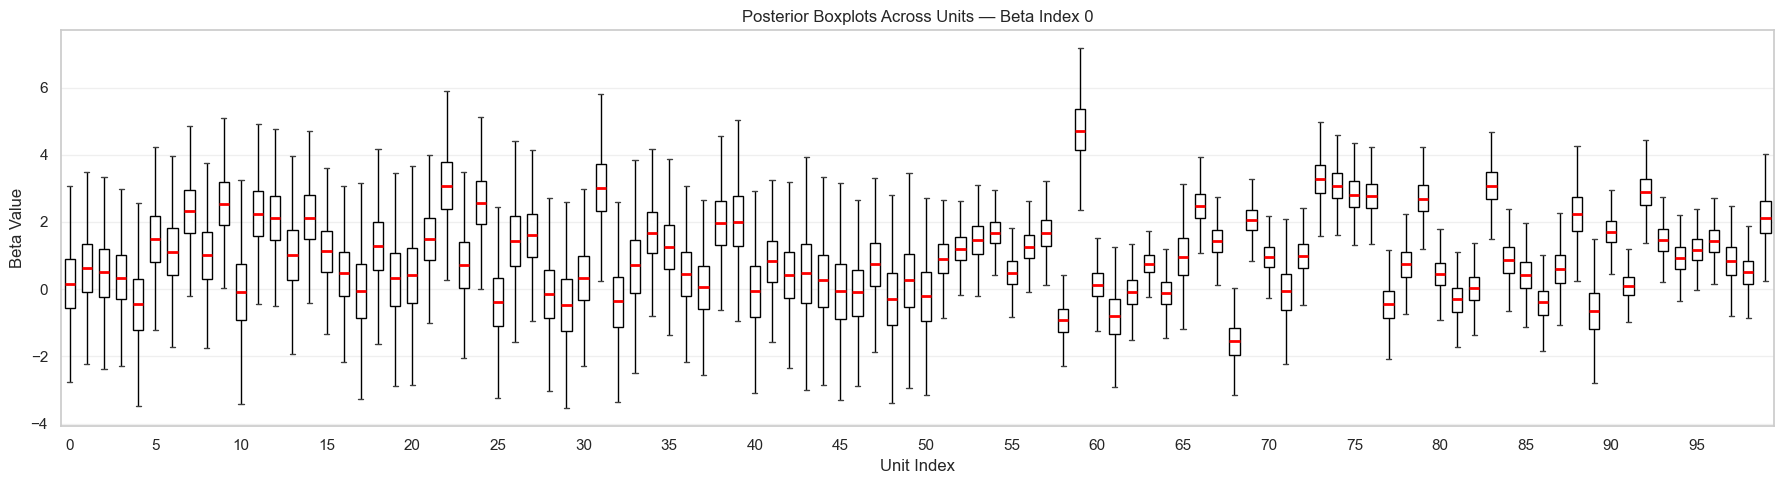

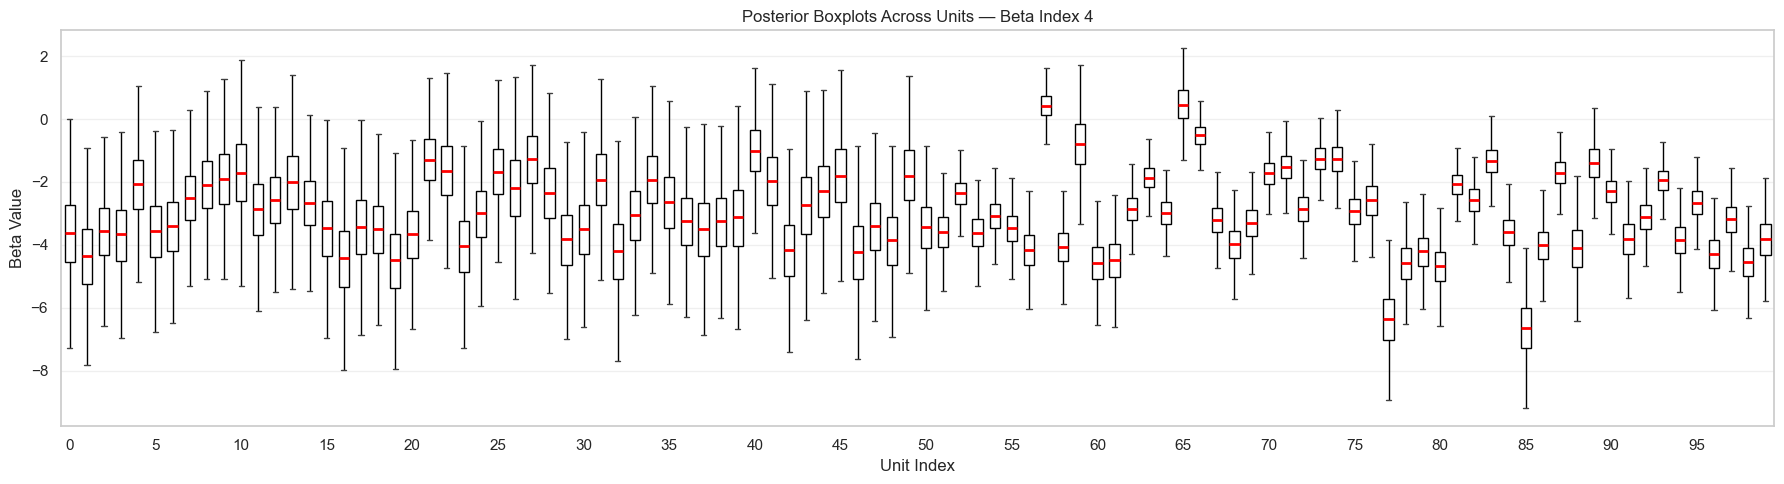


Faceted Posterior Distributions per Unit (Selected Parameters)


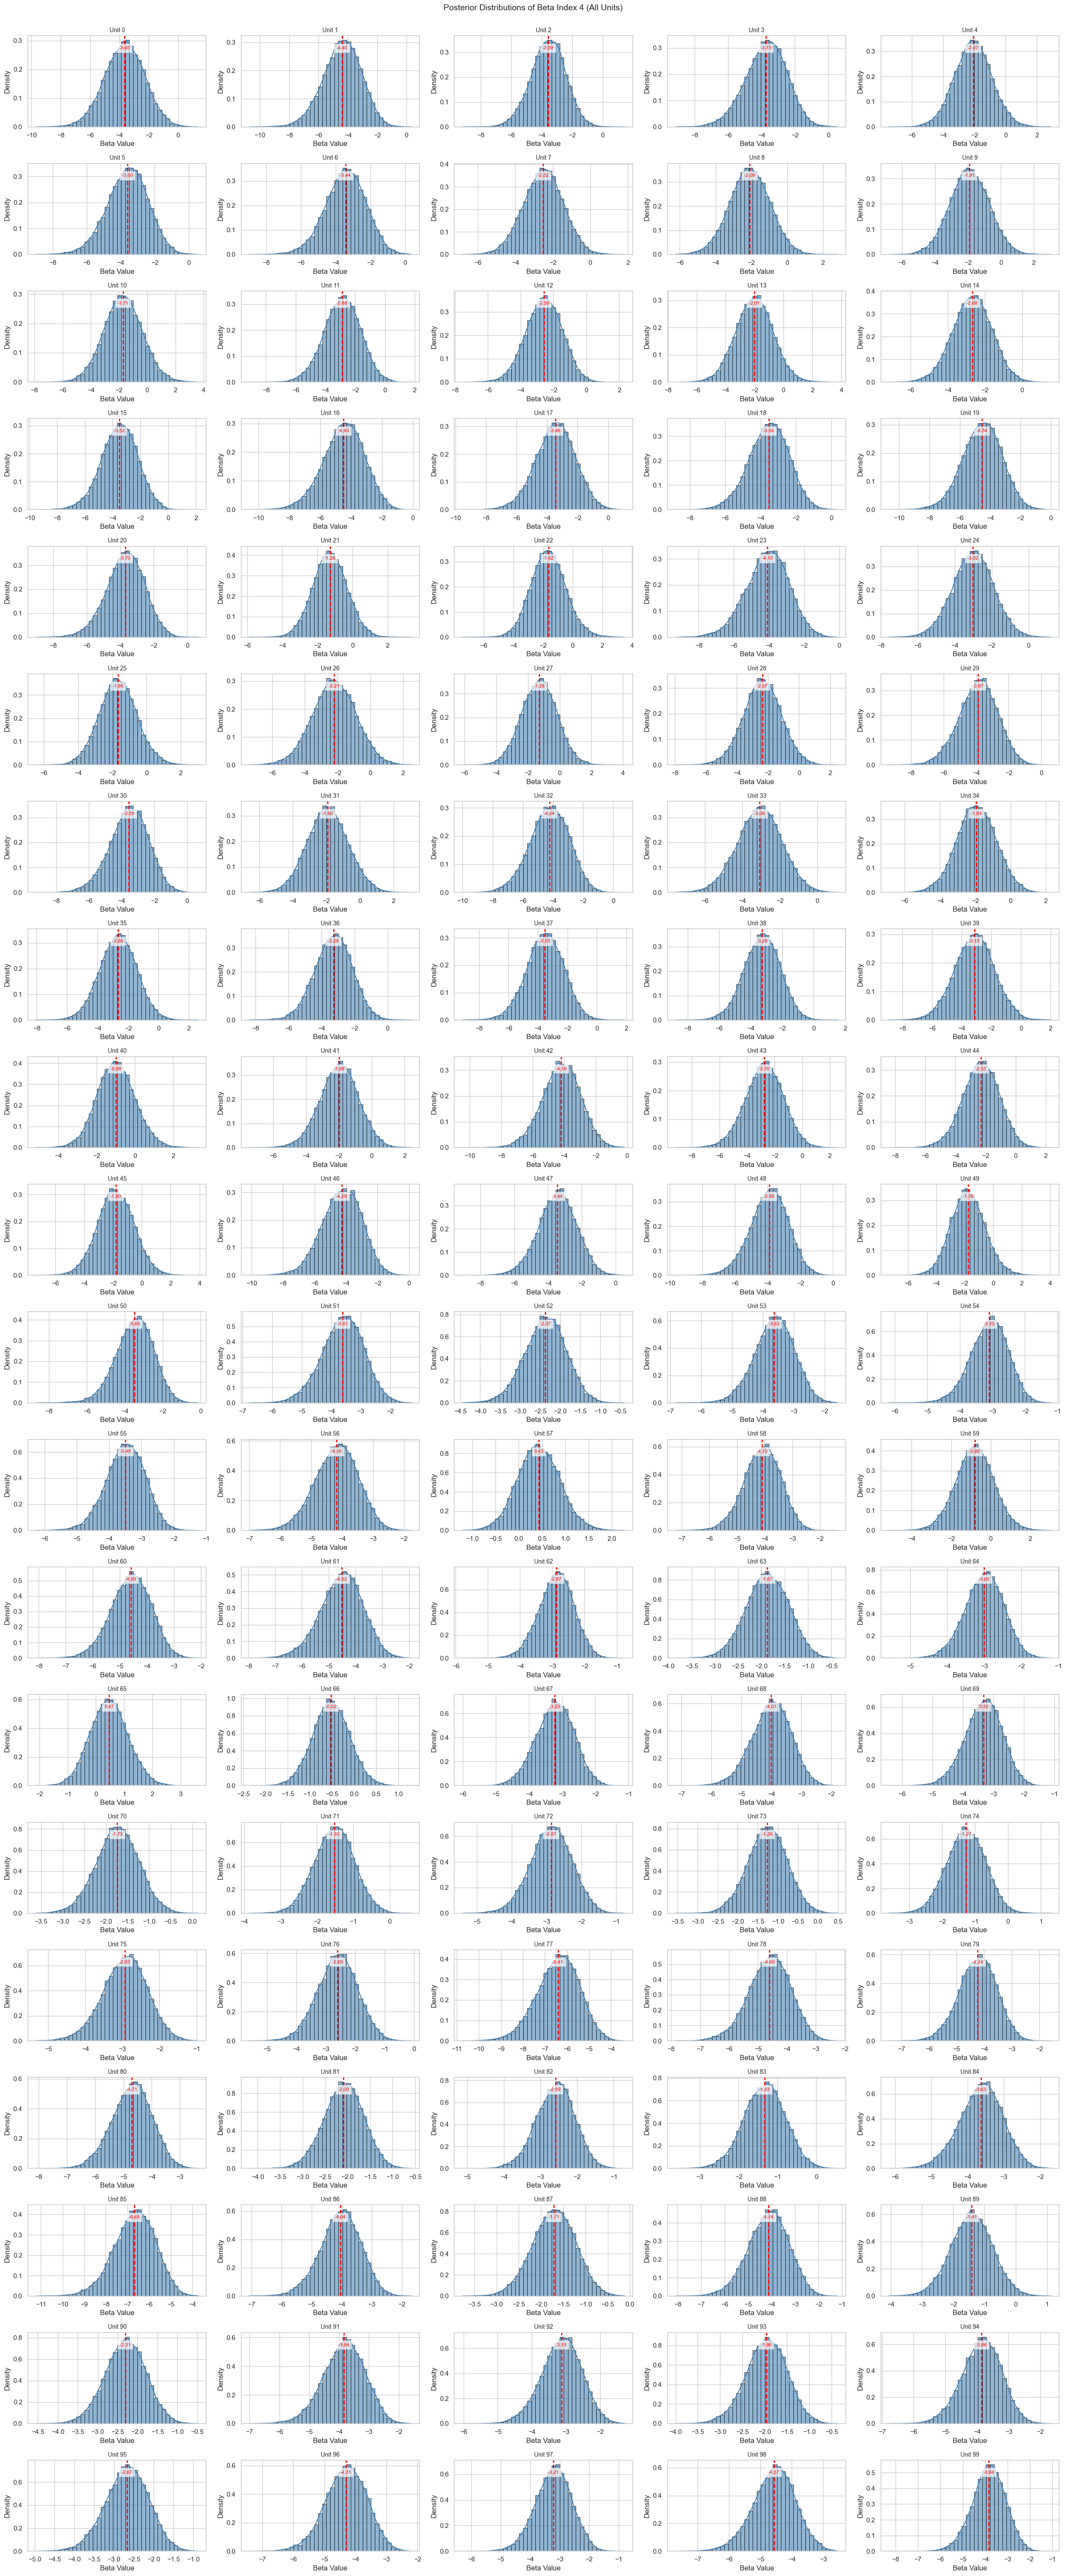

In [13]:
# =======================================
# UNIT-LEVEL BETA POSTERIOR DISTRIBUTIONS
# =======================================

# Boxplots
print("\nBoxplots (Posterior Ranges)")
def plot_unit_betas_boxplot(samples, params=None, figsize=(18, 5)):
    chains, n_samples, n_units, n_params_total = samples.shape
    if params is None:
        params = list(range(n_params_total))
    for param_idx in params:
        traces = samples[..., :, param_idx]
        traces_2d = traces.reshape(-1, n_units)
        
        plt.figure(figsize=figsize)
        sns.boxplot(
            data=traces_2d,
            color="white",
            showcaps=True,
            boxprops={'facecolor': 'white', 'edgecolor': 'black'},
            whiskerprops={'color': 'black'},
            medianprops={'color': 'red', 'linewidth': 2},
            showfliers=False,
            width=0.6
        )
        plt.xticks(range(0, n_units, 5))
        plt.title(f"Posterior Boxplots Across Units — Beta Index {param_idx}")
        plt.xlabel("Unit Index")
        plt.ylabel("Beta Value")
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()

# Plot boxplots for individual betas for index 0 and 4
plot_unit_betas_boxplot(samples["beta_i"], params=[0, 4])  # Intercept and Price Slope

# Faceted histograms with KDE for parameter list (longer runtime)
print("\nFaceted Posterior Distributions per Unit (Selected Parameters)")
def plot_unit_beta_distributions(samples_dict, beta_index, bins=40):
    """
    Faceted histograms with KDE for all units, focusing on one beta index.
    """
    beta_samples = samples_dict["beta_i"]  # (chains, draws, units, betas)
    n_units = beta_samples.shape[2]
    
    # Flatten chains and draws to (units, posterior_samples)
    flat = beta_samples[..., :, beta_index].reshape(-1, n_units).T
    
    ncols = 5
    nrows = int(np.ceil(n_units / ncols))
    plt.figure(figsize=(5 * ncols, 3 * nrows))
    
    for unit in range(n_units):
        unit_samples = flat[unit]
        mean_val = np.mean(unit_samples)
        
        ax = plt.subplot(nrows, ncols, unit + 1)
        sns.histplot(unit_samples, bins=bins, kde=True, stat="density", 
                    alpha=0.6, color="steelblue", edgecolor="black")
        
        # Mean line
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2)
        ax.text(mean_val, ax.get_ylim()[1] * 0.85,
               f"{mean_val:.2f}", color="red", ha="center", fontsize=8,
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        
        ax.set_title(f"Unit {unit}", fontsize=10)
        ax.set_xlabel("Beta Value")
        ax.set_ylabel("Density")
    
    plt.suptitle(f"Posterior Distributions of Beta Index {beta_index} (All Units)",
                fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()

# Plot for key parameters
for param_idx in [4]:  # simply price slope
    plot_unit_beta_distributions(samples, param_idx)

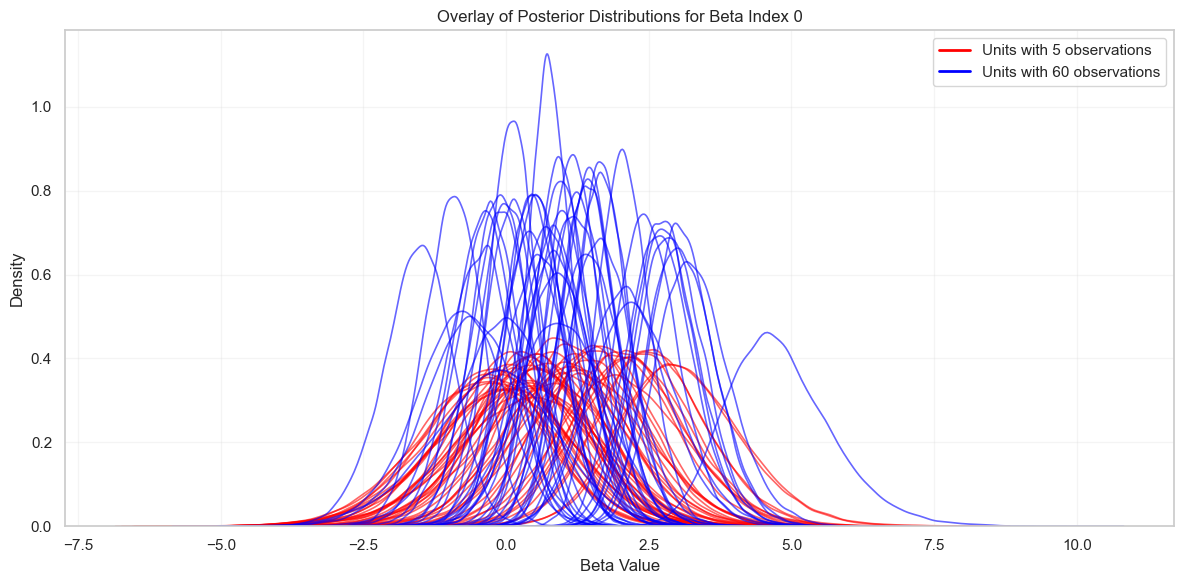

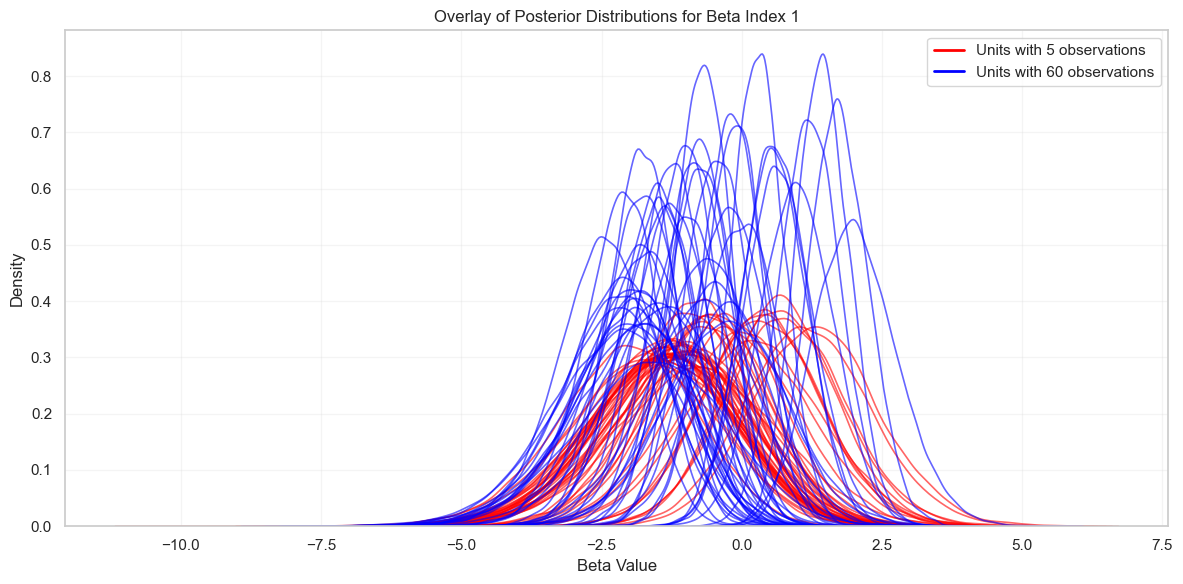

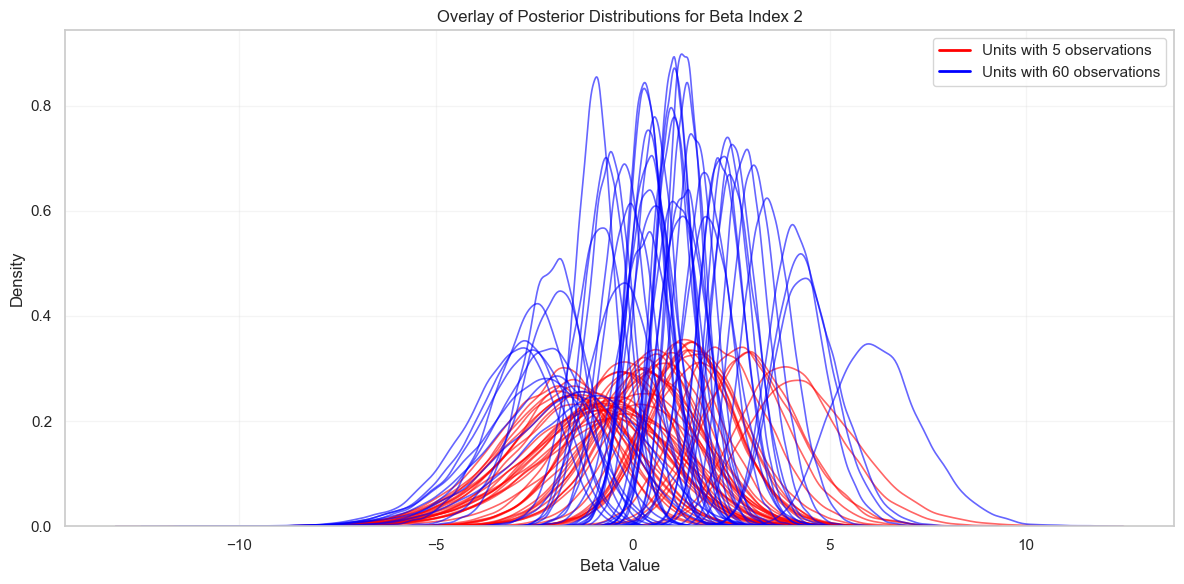

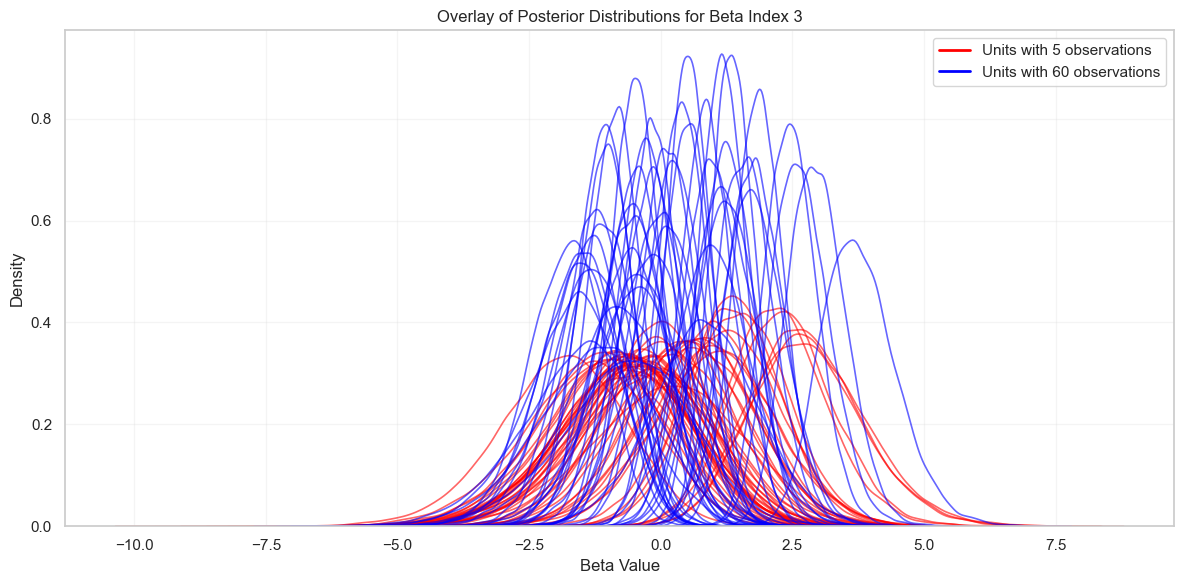

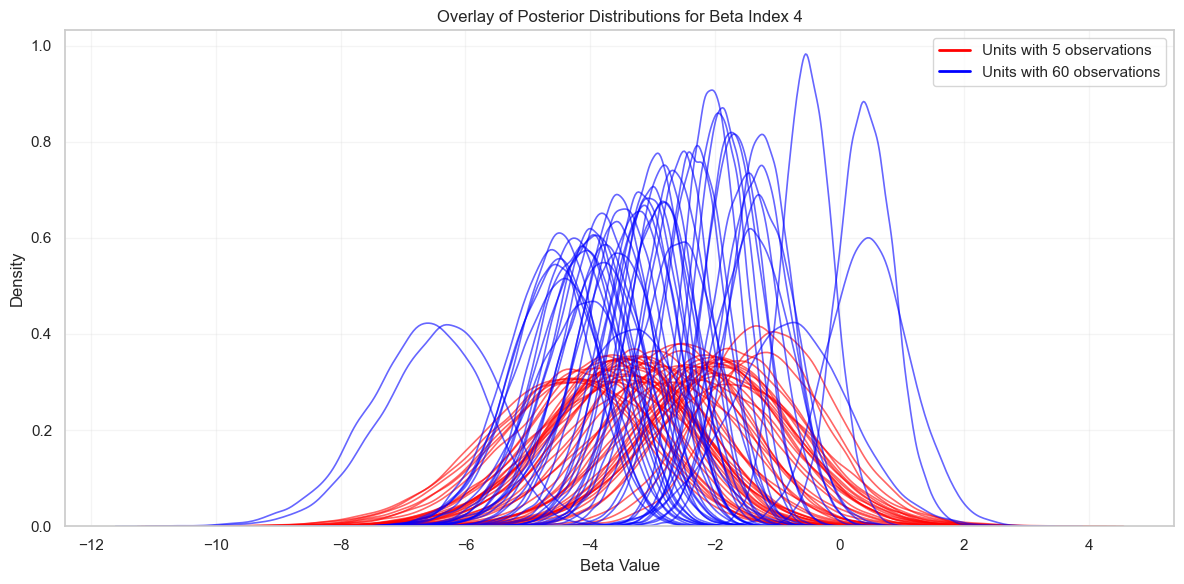

In [14]:
# ================================
# OVERLAID POSTERIOR DISTRIBUTIONS
# ================================

def plot_all_units_overlay(samples_dict, beta_index):
    """
    KDE overlay plot for all units, color-coded by data availability.
    """
    beta = samples_dict["beta_i"]  # (chains, draws, units, betas)
    n_units = beta.shape[2]
    
    # Flatten (chains * draws) for each unit
    flat = beta[..., :, beta_index].reshape(-1, n_units).T
    
    plt.figure(figsize=(12, 6))
    for unit in range(n_units):
        # Color by data availability (example: first 50 units = 5 obs, rest = 50 obs)
        color = "red" if unit < 50 else "blue"
        sns.kdeplot(flat[unit], linewidth=1.2, color=color, alpha=0.6)
    
    # Legend
    plt.plot([], [], color="red", linewidth=2, label="Units with 5 observations")
    plt.plot([], [], color="blue", linewidth=2, label="Units with 60 observations")
    plt.legend(fontsize=11)
    
    plt.title(f"Overlay of Posterior Distributions for Beta Index {beta_index}")
    plt.xlabel("Beta Value")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

for param_idx in range(n_params):
    plot_all_units_overlay(samples, param_idx)

Here we can nicely observe the estimated the bet coefficients for each unit. WE colored the distribution of units with only 5 observations red and the ones with 50 observations in blue. It can be nicely observed that units with little observations have a larger estimated range since the prior has a bigger impact on those units compared to units with with more data (observations).

Mu posterior overlays for all parameters:


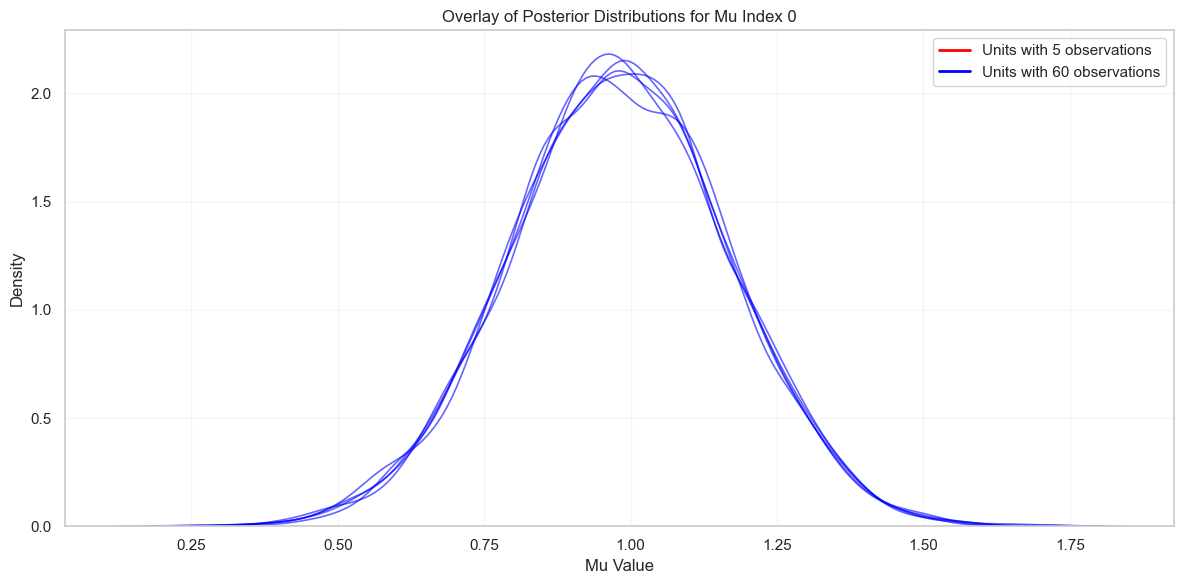

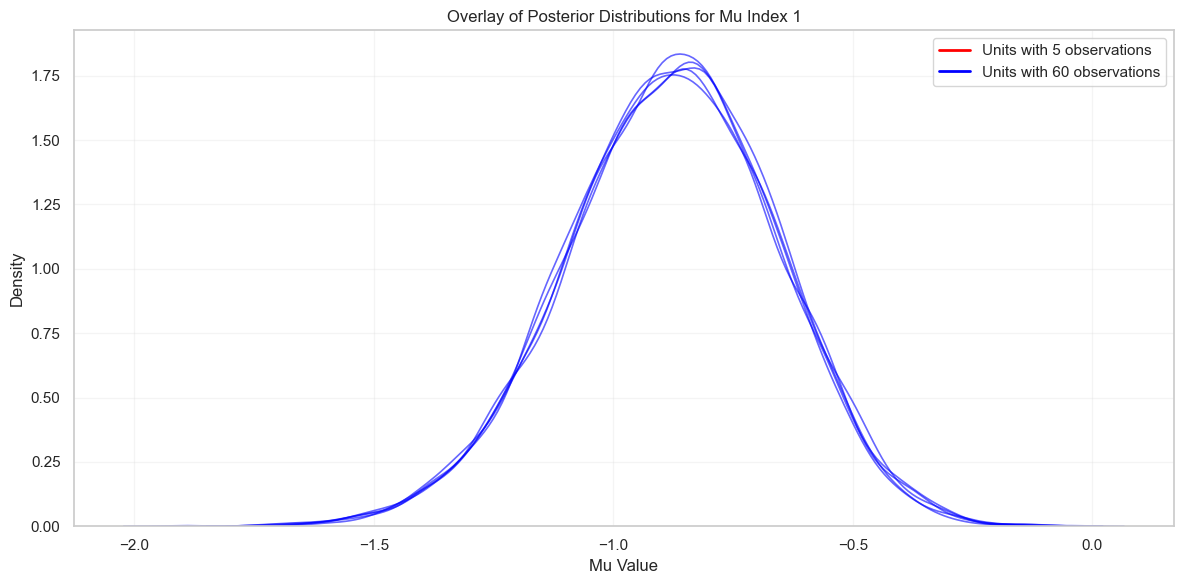

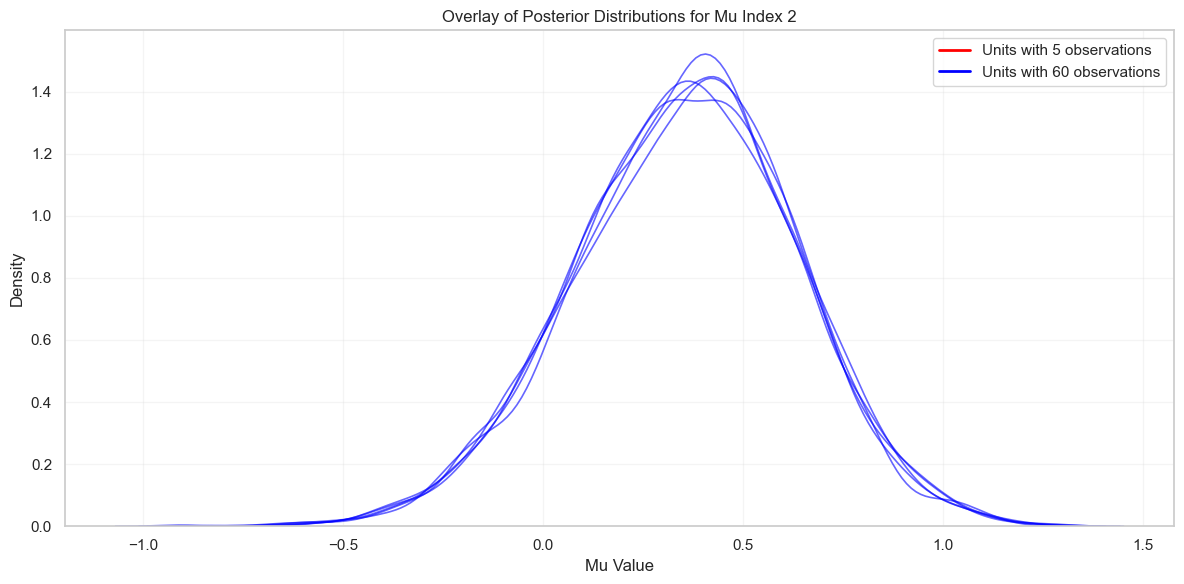

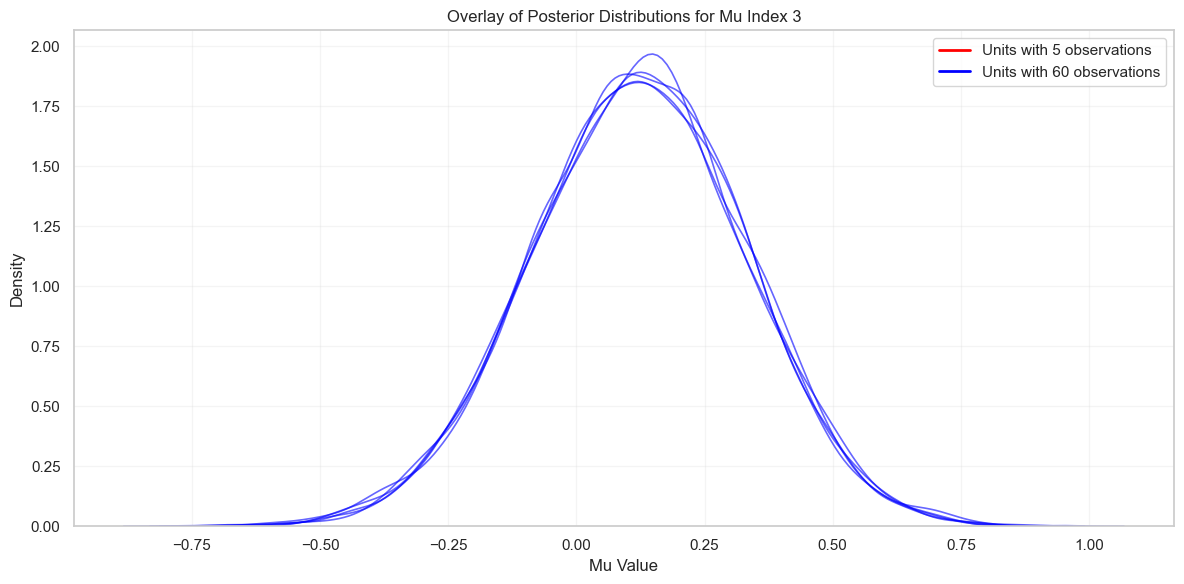

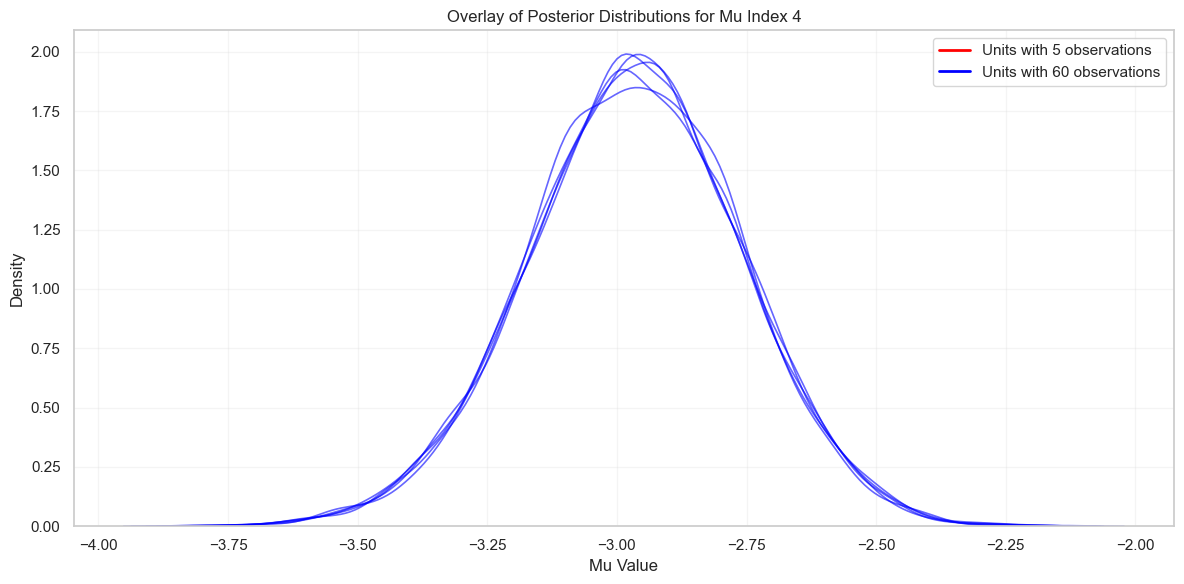

In [15]:
# =================================
# GLOBAL MU POSTERIOR DISTRIBUTIONS
# =================================

def plot_all_units_overlay_mu(samples_dict, mu_index):
    """
    KDE overlay for mu parameters across all units.
    """
    mu = samples_dict["mu"]  # (chains, draws, units, mus)
    n_units = mu.shape[2]
    
    flat = mu[..., :, mu_index].reshape(-1, n_units).T
    
    plt.figure(figsize=(12, 6))
    for unit in range(n_units):
        sns.kdeplot(flat[unit], linewidth=1.2, color="blue", alpha=0.6)
    
    plt.plot([], [], color="red", linewidth=2, label="Units with 5 observations")
    plt.plot([], [], color="blue", linewidth=2, label="Units with 60 observations")
    plt.legend(fontsize=11)
    
    plt.title(f"Overlay of Posterior Distributions for Mu Index {mu_index}")
    plt.xlabel("Mu Value")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

print("Mu posterior overlays for all parameters:")
for mu_index in range(n_params):
    plot_all_units_overlay_mu(samples, mu_index)


All Beta Indices (Pooled Across Units)


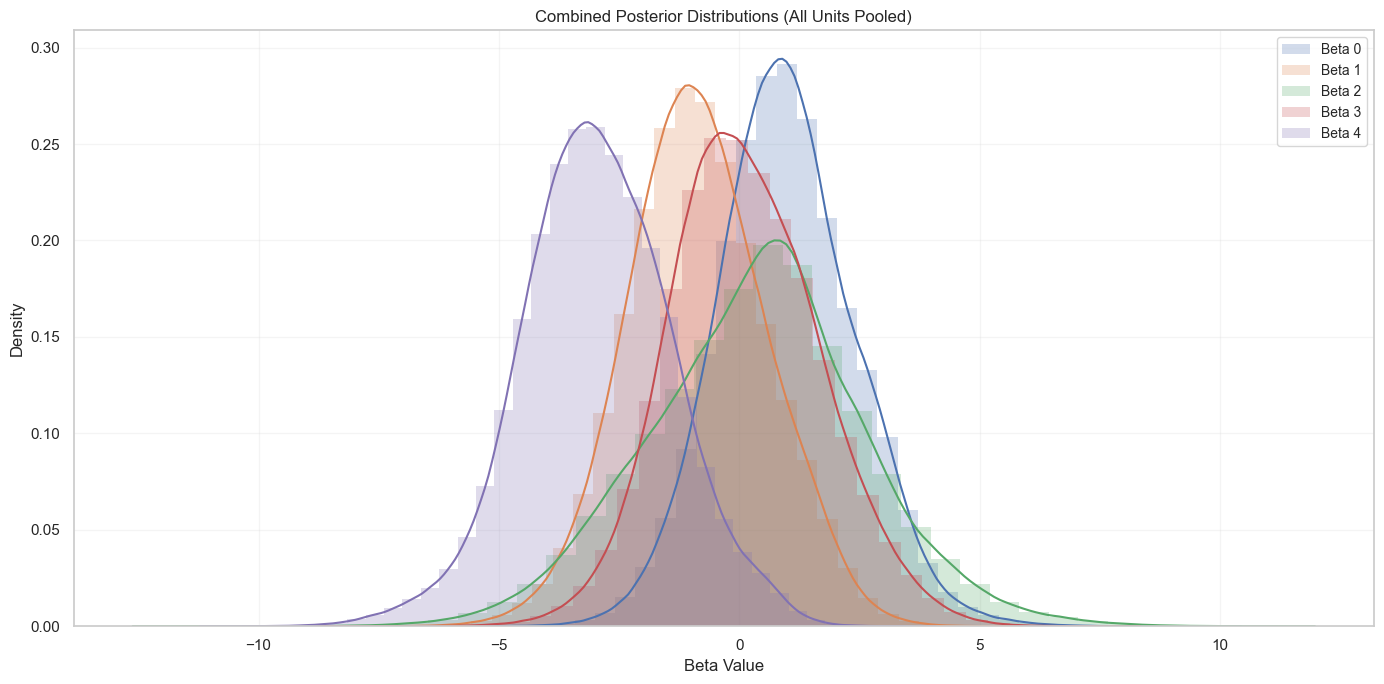


Individual Beta Parameters (Pooled Across Units)


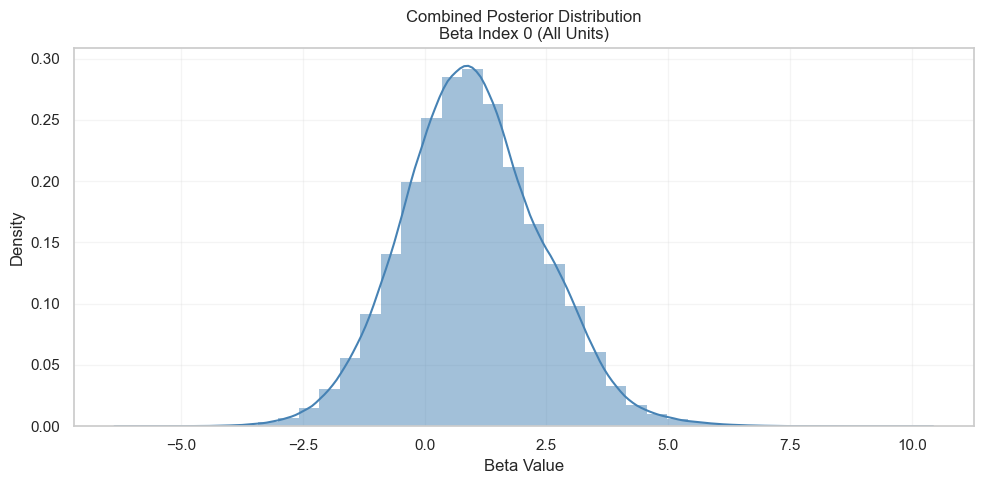

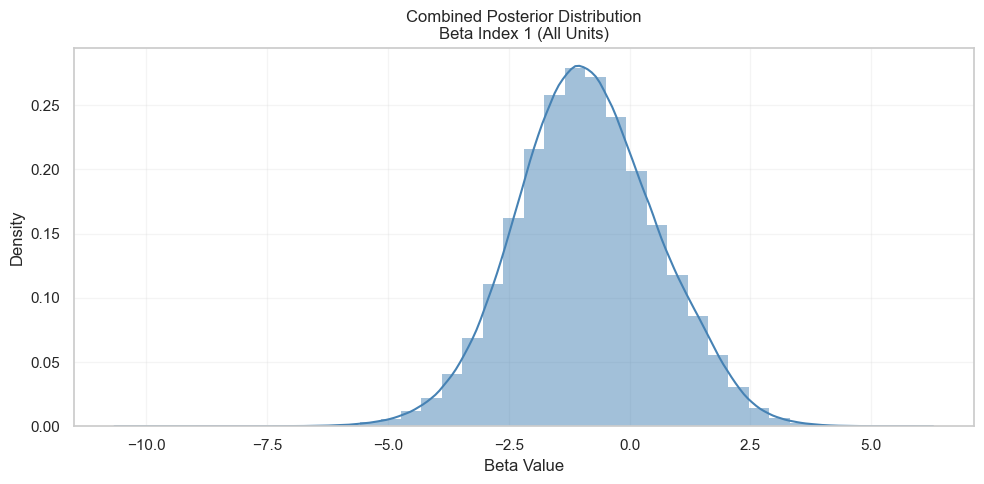

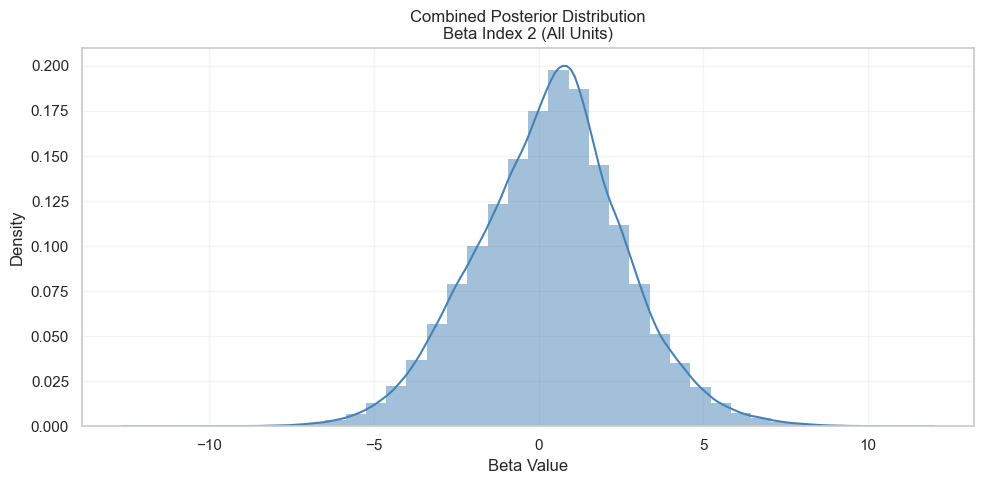

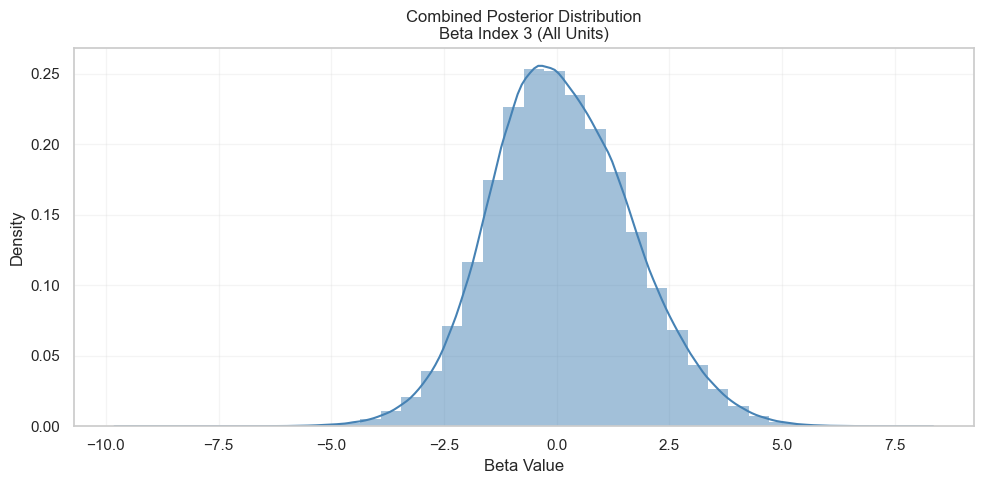

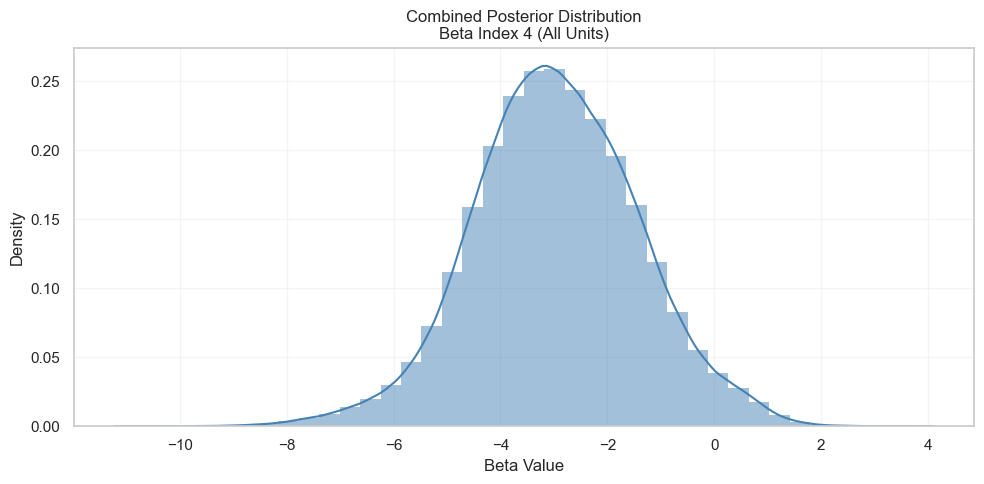

In [16]:
# ==========================================================
# COMBINED POSTERIOR DISTRIBUTIONS (Pooled Across All Units)
# ==========================================================

# All betas combined in one plot
print("\nAll Beta Indices (Pooled Across Units)")
def plot_all_betas_combined_hist_kde(samples_dict, beta_indices=None, bins=40):
    """
    Pool all beta samples across chains, draws, and units for each parameter.
    """
    if beta_indices is None:
        beta_indices = range(samples_dict["beta_i"].shape[3])
    
    beta = samples_dict["beta_i"]  # (chains, draws, units, betas)
    
    plt.figure(figsize=(14, 7))
    for b in beta_indices:
        arr = beta[..., b].reshape(-1)  # Flatten everything
        sns.histplot(arr, bins=bins, kde=True, stat="density",
                    alpha=0.25, linewidth=0, label=f"Beta {b}")
    
    plt.title("Combined Posterior Distributions (All Units Pooled)")
    plt.xlabel("Beta Value")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.2)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

plot_all_betas_combined_hist_kde(samples)

# Individual parameter pooled distributions 
print("\nIndividual Beta Parameters (Pooled Across Units)")
def plot_combined_beta_hist_kde(samples_dict, beta_index, bins=40):
    """
    Histogram + KDE for a single beta index, pooled across all units.
    """
    beta = samples_dict["beta_i"]
    arr = beta[..., beta_index].reshape(-1)  # Flatten everything
    
    plt.figure(figsize=(10, 5))
    sns.histplot(arr, bins=bins, kde=True, stat="density",
                linewidth=0, alpha=0.5, color="steelblue")
    
    plt.title(f"Combined Posterior Distribution\nBeta Index {beta_index} (All Units)")
    plt.xlabel("Beta Value")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

for param_idx in range(n_params):
    plot_combined_beta_hist_kde(samples, param_idx)